In [553]:
import pandas as pd 
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedShuffleSplit

In [554]:
# Read data 

df = pd.read_csv('data.csv')

C:\Users\HP\AppData\Local\Temp\ipykernel_29200\847141996.py:3: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


In [555]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Data discovery

In [556]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           855969 non-null  int64  
 1   member_id                    855969 non-null  int64  
 2   loan_amnt                    855969 non-null  int64  
 3   funded_amnt                  855969 non-null  int64  
 4   funded_amnt_inv              855969 non-null  float64
 5   term                         855969 non-null  object 
 6   int_rate                     855969 non-null  float64
 7   installment                  855969 non-null  float64
 8   grade                        855969 non-null  object 
 9   sub_grade                    855969 non-null  object 
 10  emp_title                    806526 non-null  object 
 11  emp_length                   812908 non-null  object 
 12  home_ownership               855969 non-null  object 
 13 

In [557]:
# Check the null value in each attributes

df.isnull().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
total_rev_hi_lim     67313
inq_fi              842681
total_cu_tl         842681
inq_last_12m        842681
default_ind              0
Length: 73, dtype: int64

# Data pre-processing

In [558]:
# total_rev_hi_lim 

# Fill missing values in total_rev_hi_lim with Simple Imputer

imputer = SimpleImputer(strategy='median')
total_rev_hi_lim = df['total_rev_hi_lim'].values.reshape(-1,1)
total_rev_hi_lim_imputed = imputer.fit_transform(total_rev_hi_lim)
df['total_rev_hi_lim'] = total_rev_hi_lim_imputed

In [559]:
# home_ownership 

# Remove rows with value ANY

df = df[df['home_ownership'] != 'ANY']
df['home_ownership'].unique()

# Level encoding for home ownership 

home_type = ['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE']  # Unique values for encoding

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(home_type)

# Encode the 'grade' column in the DataFrame
df['home_ownership'] = encoder.transform(df['home_ownership'])


In [560]:
# Purpose 

# Label encoding for purpose

df['purpose'].unique()

purposes = ['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational']

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(purposes)
# Encode the 'grade' column in the DataFrame
df['purpose'] = encoder.transform(df['purpose'])


In [561]:
# sub_grade

# Sort the order of subgrades and do label encoding

subgrades = ['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
       'A1', 'B3', 'B4', 'C2', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3',
       'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
       'F5', 'G5']

def custom_sort_key(subgrade):
    match = re.match(r'([A-Za-z]+)(\d+)', subgrade)
    letter = match.group(1)
    number = int(match.group(2))
    
    return letter, number

sorted_subgrades = sorted(subgrades, key=custom_sort_key)

# Level encoding for sorted sub-grade 

encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(sorted_subgrades)

# Encode the 'grade' column in the DataFrame
df['sub_grade'] = encoder.transform(df['sub_grade'])

In [562]:
# employment_lengths

employment_lengths = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years', 'nan']

label_encoder = LabelEncoder()

# Fit the LabelEncoder with unique values
label_encoder.fit(employment_lengths)

# Encode the attribute values
df['emp_length'] = label_encoder.transform(df['emp_length'])

In [563]:
# mths_since_last_delinq

df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(-1)

In [564]:
# mths_since_last_record

df['mths_since_last_record'] = df['mths_since_last_record'].fillna(-1)

In [565]:
# revol_util
# Handle missing value with imputer

imputer = SimpleImputer(strategy='mean')

revol_util = df['revol_util'].values.reshape(-1,1)

revol_util_imputed = imputer.fit_transform(revol_util)

df['revol_util'] = revol_util_imputed

In [566]:
# aggregate annual_inc and annual_inc_joint

df.loc[df['application_type'] == 'JOINT', 'annual_inc'] = df.loc[df['application_type'] == 'JOINT', 'annual_inc_joint']
df = df.drop('annual_inc_joint', axis=1)

In [567]:
# dti_joint

df.loc[df['application_type'] == 'JOINT', 'dti'] = df.loc[df['application_type'] == 'JOINT', 'dti_joint']
df = df.drop('dti_joint', axis=1)

In [568]:
# verification_status_joint

df.loc[df['application_type'] == 'JOINT', 'verification_status'] = df.loc[df['application_type'] == 'JOINT', 'verification_status_joint']
df = df.drop('verification_status_joint', axis=1)

In [569]:
# term 
# Label encoding for term

term = [' 36 months', ' 60 months']  # Unique values for encoding

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(term)

# Encode the 'grade' column in the DataFrame
df['term'] = encoder.transform(df['term'])

In [570]:
# verification_status

veri = ['Not Verified', 'Source Verified', 'Verified']  # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(veri)


df['verification_status'] = encoder.transform(df['verification_status'])

In [571]:
# pymnt_plan

plan = ['n', 'y']  # Unique values for encoding

encoder = LabelEncoder()
encoder.fit(plan)
df['pymnt_plan'] = encoder.transform(df['pymnt_plan'])

In [572]:
# application_type

type = ['INDIVIDUAL', 'JOINT'] # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(type)

df['application_type'] = encoder.transform(df['application_type'])

In [573]:

# initial_list_status

status = ['f', 'w'] # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(status)

df['initial_list_status'] = encoder.transform(df['initial_list_status'])

In [574]:
# Fill missing last credit pull
df['last_credit_pull_d'].fillna("25-07-2023", inplace=True)

In [575]:
# Credit History Length:
# Calculated as: last_credit_pull - earliest_cr_line
def date_difference(date_str1, date_str2):
    # Convert date strings to datetime objects
    date_format = "%d-%m-%Y"
    date1 = datetime.strptime(date_str1, date_format)
    date2 = datetime.strptime(date_str2, date_format)

    # Calculate the difference
    difference = date2 - date1

    # Return the difference in days
    return difference.days

df['credit_history_length'] = df.apply(lambda row: date_difference(row['earliest_cr_line'], row['last_credit_pull_d']), axis=1)

# Swap the values and column names
df['default_ind'], df['credit_history_length'] = df['credit_history_length'], df['default_ind']
df.rename(columns={'default_ind': 'credit_history_length', 'credit_history_length': 'default_ind'}, inplace=True)

In [576]:
# Drop not usable attributes 

remove_col = [
    'id',
    'member_id',
    'emp_title',
    'issue_d',
    'desc',
    'title',
    'zip_code',
    'addr_state',
    'earliest_cr_line',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'last_credit_pull_d',
    'collections_12_mths_ex_med',
    'mths_since_last_major_derog',
    'policy_code',
    'tot_coll_amt',
    'tot_cur_bal', 
    'open_acc_6m',
    'open_il_6m', 
    'open_il_12m', 
    'open_il_24m', 
    'mths_since_rcnt_il', 
    'total_bal_il', 
    'il_util', 
    'open_rv_12m' ,
    'open_rv_24m', 
    'max_bal_bc', 
    'all_util', 
    'inq_fi', 
    'total_cu_tl', 
    'inq_last_12m',
    'grade'
]

df = df.drop(remove_col, axis=1)

In [577]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,application_type,acc_now_delinq,total_rev_hi_lim,credit_history_length,default_ind
0,5000,5000,4975.0,0,10.65,162.87,6,1,4,24000.0,...,5000.00,861.07,0.00,0.00,0.00,0,0,23800.0,11322,0
1,2500,2500,2500.0,1,15.27,59.83,13,10,4,30000.0,...,456.46,435.17,0.00,117.08,1.11,0,0,23800.0,5267,1
2,2400,2400,2400.0,0,15.96,84.33,14,1,4,12252.0,...,2400.00,603.65,0.00,0.00,0.00,0,0,23800.0,5174,0
3,10000,10000,10000.0,0,13.49,339.31,10,1,4,49200.0,...,10000.00,2209.33,16.97,0.00,0.00,0,0,23800.0,6909,0
4,3000,3000,3000.0,1,12.69,67.79,9,0,4,80000.0,...,2233.10,1009.07,0.00,0.00,0.00,0,0,23800.0,7305,0


In [578]:
df.isnull().sum()

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
sub_grade                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
pymnt_plan                 0
purpose                    0
dti                        0
delinq_2yrs                0
inq_last_6mths             0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
initial_list_status        0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
application_type           0
acc_now_delinq

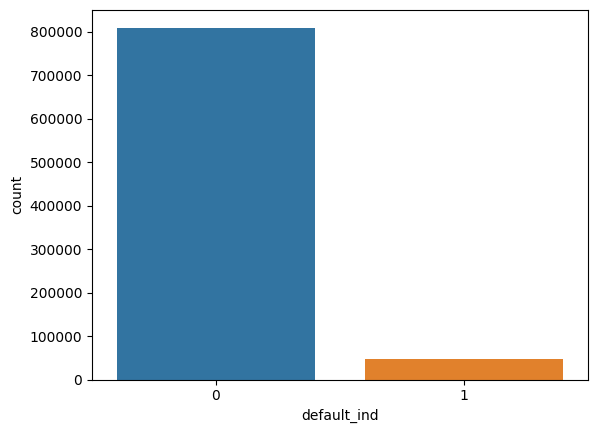

In [579]:
# Visualize default_ind attribute

sns.countplot(data=df, x='default_ind')
plt.show()

## New feature using user defined transformer

In [580]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class CreditUtilizationRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, include=True):
        self.revol_bal_col = 'revol_bal'
        self.annual_inc_col = 'annual_inc'
        self.installment_col = 'installment'
        self.total_rec_prncp_col = 'total_rec_prncp'
        self.funded_amnt_col = 'funded_amnt'

        self.include_rev_to_inc_ratio = include
        self.include_loan_to_inc_ratio = include
        self.include_repayment_progress = include


    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Find index of columns
        revol_bal_ix = np.where(X.columns == self.revol_bal_col)[0][0]
        annual_inc_ix = np.where(X.columns == self.annual_inc_col)[0][0]
        installment_ix = np.where(X.columns == self.installment_col)[0][0]
        total_rec_prncp_ix = np.where(X.columns == self.total_rec_prncp_col)[0][0]
        funded_amnt_ix = np.where(X.columns == self.funded_amnt_col)[0][0]

        # Calculate the Revolving Credit Balance to Annual Income Ratio.
        rev_to_inc_ratio = X.iloc[:, revol_bal_ix] / X.iloc[:, annual_inc_ix]

        # Calculate the Loan Payment-to-Income Ratio.
        loan_to_inc_ratio = X.iloc[:, installment_ix] / (X.iloc[:, annual_inc_ix] / 12)

        # Calculate the Repayment Progress.
        repayment_progress = (X.iloc[:, total_rec_prncp_ix] / X.iloc[:, funded_amnt_ix]) * 100

        if self.include_rev_to_inc_ratio:
            # Add the calculated Revolving Credit Balance to Annual Income Ratio as a new column to the input data.
            X['Rev_to_Inc_Ratio'] = rev_to_inc_ratio

        if self.include_loan_to_inc_ratio:
            # Add the calculated Loan Payment-to-Income Ratio as a new column to the input data.
            X['Loan_Payment_to_Income_Ratio'] = loan_to_inc_ratio

        if self.include_repayment_progress:
            # Add the calculated Repayment Progress as a new column to the input data.
            X['Repayment_Progress'] = repayment_progress

        return X


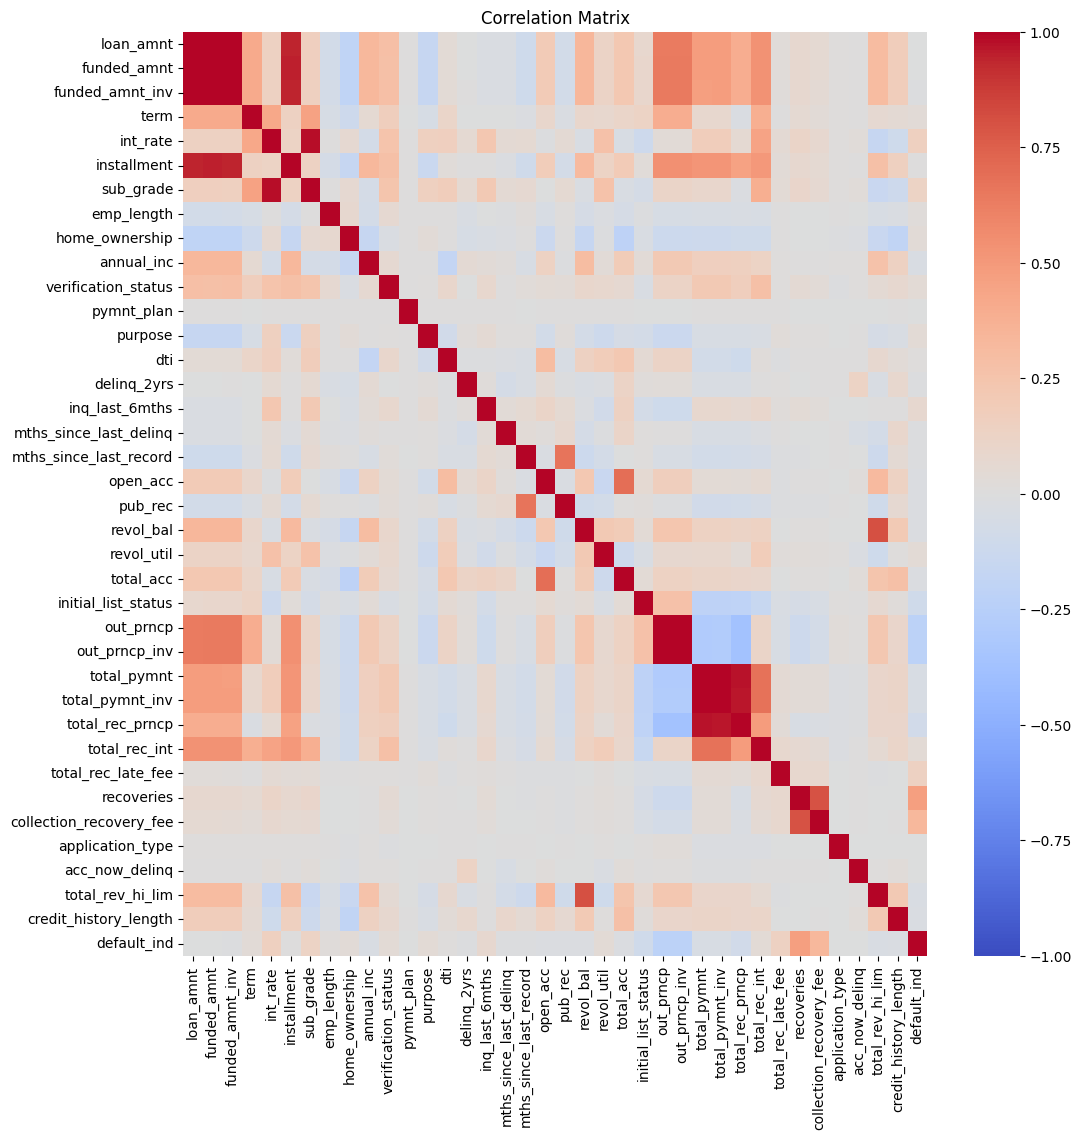

In [581]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = df.corr()

# Select the correlation values with 'default_ind'
target_corr = corr_matrix['default_ind']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

# Model selection and training

In [582]:
selected_features = [
    'collection_recovery_fee'   ,                  
    'acc_now_delinq' ,                                    
    'funded_amnt'   ,               
    'funded_amnt_inv'   ,            
    'mths_since_last_record' ,       
    'delinq_2yrs'   ,                          
    'dti'            ,              
    'mths_since_last_delinq'  ,       
    'emp_length',                      
    'pub_rec'   ,                  
    'revol_bal'    ,                                
    'credit_history_length'  ,        
    'term'   ,                       
    'home_ownership' ,                                
    'total_rev_hi_lim'  ,              
    'total_pymnt'      ,                     
    'total_pymnt_inv'  ,              
    'purpose'   ,                   
    'revol_util'   ,                 
    'total_rec_int'   ,               
    'inq_last_6mths'  ,              
    'total_rec_prncp' ,                        
    'sub_grade'        ,             
    'total_rec_late_fee'   ,          
    'int_rate'   ,                    
    'out_prncp_inv'  ,                 
    'out_prncp'   ,                       
    'recoveries'                     
]
X = df[selected_features]
y = df['default_ind']

#### StratifiedShuffleSplit Sampling

In [583]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

def stratified_sampling_and_undersampling(X, y, test_size=0.2, random_state=42):
    """
    Perform stratified sampling and undersampling on the input dataset.

    Parameters:
        X (array-like): Input features.
        y (array-like): Target variable.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int or None): Random seed for reproducibility.

    Returns:
        X_train_undersampled (array-like): Undersampled training features.
        X_test (array-like): Test features.
        y_train_undersampled (array-like): Undersampled training target variable.
        y_test (array-like): Test target variable.
    """
    # Split the data into training and testing sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    # Create a DataFrame to easily manipulate the data
    data = np.column_stack((X_train, y_train))
    data_df = pd.DataFrame(data, columns=np.arange(X_train.shape[1]).tolist() + ['default_ind'])

    # Get the counts of each class
    class_counts = data_df['default_ind'].value_counts()

    # Calculate the target count of the least represented class
    min_class_count = class_counts.min()

    # Undersample the majority class to balance the dataset
    undersampled_data = data_df.groupby('default_ind', group_keys=False).apply(lambda x: resample(x, n_samples=min_class_count, random_state=random_state))

    # Separate the features and target variable after undersampling
    X_train_undersampled = undersampled_data.iloc[:, :-1].values
    y_train_undersampled = undersampled_data['default_ind'].values

    return X_train_undersampled, X_test, y_train_undersampled, y_test

In [584]:
from imblearn.over_sampling import SMOTE

def oversampling(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    # Instantiate the SMOTE object
    smote = SMOTE(random_state=42)

    # Perform SMOTE only on the training data
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    return X_train_balanced, X_test, y_train_balanced, y_test

### NB Classifier

In [585]:
# Create a Gaussian Naive Bayes classifier
X_train, X_test, y_train, y_test = stratified_sampling_and_undersampling(X, y)
nb_classifier = GaussianNB()

# Train the classifier on the training data
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [586]:
y_pred = nb_classifier.predict(X_test)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Oversampling

In [587]:
X2_train, X2_test, y2_train, y2_test = oversampling(X, y)
nb_classifier_over = GaussianNB()

# Train the classifier on the training data
nb_classifier_over.fit(X2_train, y2_train)

GaussianNB()

In [588]:
y_pred_o = nb_classifier_over.predict(X2_test)

# Fine tune the model

In [589]:
# Decide to use new generated features

transformer_with_features = CreditUtilizationRatioTransformer(include=True)

# Apply the transformer to add the new features to df.
df = transformer_with_features.transform(df)

In [590]:
selected_features.append('Repayment_Progress')
selected_features.append('Loan_Payment_to_Income_Ratio')
selected_features.append('Rev_to_Inc_Ratio')
X1 = df[selected_features]
y1 = df['default_ind']

In [591]:
# Create a Gaussian Naive Bayes classifier
X1_train, X1_test, y1_train, y1_test = stratified_sampling_and_undersampling(X1, y1)
nb_classifier_hyper = GaussianNB()

# Train the classifier on the training data
nb_classifier_hyper.fit(X1_train, y1_train)

GaussianNB()

In [592]:
y_pred_hyperparam = nb_classifier_hyper.predict(X1_test)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


In [593]:
X3_train, X3_test, y3_train, y3_test = oversampling(X1, y1)
nb_classifier_hyper_o = GaussianNB()

# Train the classifier on the training data
nb_classifier_hyper_o.fit(X3_train, y3_train)

GaussianNB()

In [594]:
y_pred_hyperparam_o = nb_classifier_hyper_o.predict(X3_test)

# Eveluate the outcome

In [595]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy_o = accuracy_score(y2_test, y_pred_o)
accuracy_hyperparam = accuracy_score(y1_test, y_pred_hyperparam)
accuracy_hyperparam_o = accuracy_score(y3_test, y_pred_hyperparam_o)
print("Accuracy of default NB:", accuracy)
print("Accuracy of default NB (Oversampling):", accuracy_o)
print("Accuracy of default NB with hyper parameter:", accuracy_hyperparam)
print("Accuracy of default NB with hyper parameter (Oversampling):", accuracy_hyperparam_o)

Accuracy of default NB: 0.970775844947837
Accuracy of default NB (Oversampling): 0.9710562286061427
Accuracy of default NB with hyper parameter: 0.9721135086510041
Accuracy of default NB with hyper parameter (Oversampling): 0.9724990361811746


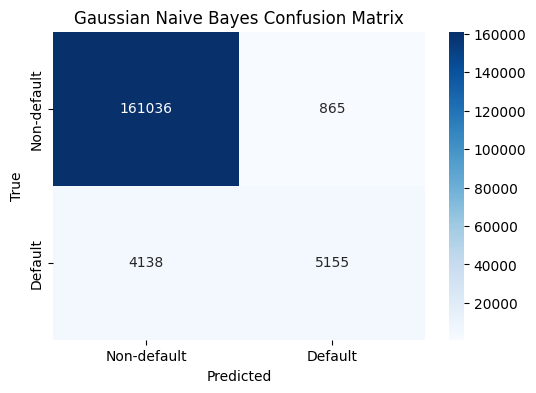

In [596]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], yticklabels=['Non-default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.show()

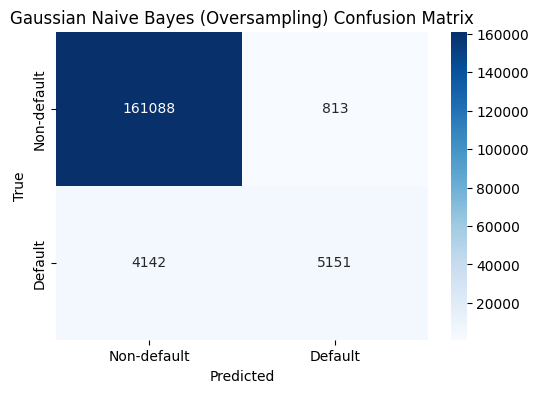

In [597]:
# Generate the confusion matrix
cm = confusion_matrix(y2_test, y_pred_o)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], yticklabels=['Non-default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gaussian Naive Bayes (Oversampling) Confusion Matrix')
plt.show()

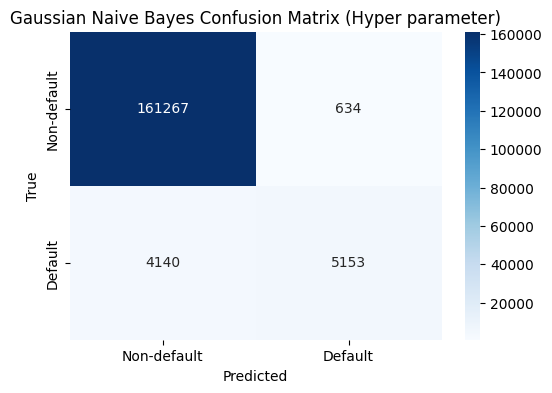

In [598]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_hyperparam)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], yticklabels=['Non-default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gaussian Naive Bayes Confusion Matrix (Hyper parameter)')
plt.show()

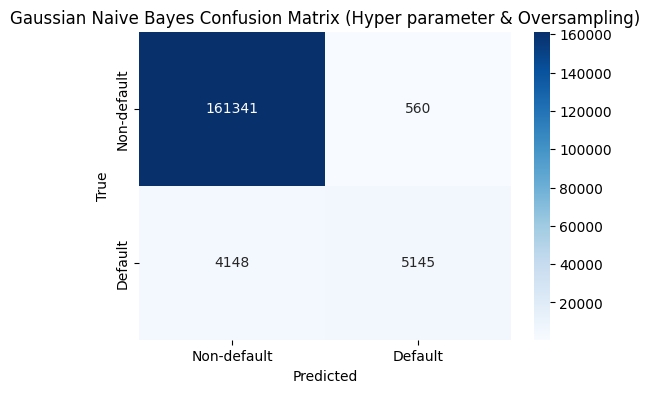

In [599]:
# Generate the confusion matrix
cm = confusion_matrix(y3_test, y_pred_hyperparam_o)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], yticklabels=['Non-default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gaussian Naive Bayes Confusion Matrix (Hyper parameter & Oversampling)')
plt.show()